## Load Encoded Captions

In [1]:
import h5py
from os.path import join
import numpy as np
import random
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
data_dir = 'Data'
h = h5py.File(join(data_dir, 'flower_tv.hdf5'))

In [3]:
flower_captions = {}
for ds in dict(h).items():
    flower_captions[ds[0]] = np.array(ds[1])

In [4]:
# each image has 5 captions each vectorized into 4800 vectors
flower_captions['image_05349.jpg']

array([[  1.12434858e-02,  -1.09033026e-02,  -5.40558062e-03, ...,
          4.71095368e-03,   3.07553913e-03,  -7.88170006e-03],
       [  5.23057580e-03,  -1.70876943e-02,  -5.15448023e-03, ...,
          1.07166674e-02,   1.85983779e-03,  -2.78546521e-03],
       [  2.36820132e-02,  -7.51516828e-03,  -5.73695637e-03, ...,
          6.86524883e-02,   1.42409978e-03,  -1.04672341e-02],
       [  3.76328523e-03,   2.30614142e-03,  -4.49462328e-03, ...,
         -1.71718730e-05,   2.64344364e-03,  -8.79086379e-04],
       [  1.11399777e-02,  -4.91742557e-03,  -8.57677124e-03, ...,
          6.91645890e-02,   1.77751575e-03,  -6.18656259e-03]], dtype=float32)

## How to create embedding with a new sentence

In [5]:
import imp
imp.load_source("skipthoughts", "./skip-thoughts/skipthoughts.py") 
import skipthoughts

model = skipthoughts.load_model()
#skipthoughts.load_tables()
encoder = skipthoughts.Encoder(model)


Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


In [6]:
imp.load_source("skipthoughts", "./skip-thoughts/skipthoughts.py") 
import skipthoughts
vectors = encoder.encode(["Hello World!", "how are you"],verbose=True)

3


In [7]:
vectors

array([[ 0.00289424, -0.01340304, -0.0031364 , ..., -0.00020494,
         0.00080485, -0.00859977],
       [ 0.00222143, -0.01256226, -0.01843037, ..., -0.00421009,
         0.01834102, -0.01412066]], dtype=float32)

## Prep Inputs For GAN

In [8]:
def load_training_data(data_dir, data_set='flowers'):
	if data_set == 'flowers':
		h = h5py.File(join(data_dir, 'flower_tv.hdf5'))
		flower_captions = {}
		for ds in h.items():
			flower_captions[ds[0]] = np.array(ds[1])
		image_list = [key for key in flower_captions]
		image_list.sort()

		img_75 = int(len(image_list)*1) # can be changed if don't need all pic
		training_image_list = image_list[0:img_75]
		#random.shuffle(training_image_list)
		
		return {
			'image_list' : training_image_list,
			'captions' : flower_captions,
			'data_length' : len(training_image_list)
		}

flower_cap = load_training_data(data_dir)

In [9]:
print (flower_cap['image_list'][0])
print (flower_cap['captions'][flower_cap['image_list'][0]])
print (flower_cap['data_length'])

image_00001.jpg
[[ 0.00247043 -0.00978464 -0.01372992 ..., -0.02817912  0.03375437
  -0.00589225]
 [ 0.01244221 -0.01928648 -0.00613386 ..., -0.0065219   0.00466952
  -0.01222099]
 [ 0.01298153 -0.00059234 -0.00383552 ...,  0.02389688  0.00137579
  -0.01621519]
 [ 0.00446556 -0.0084612  -0.00732049 ...,  0.00601037  0.00218833
   0.00555609]
 [ 0.01124559 -0.0070828  -0.0034986  ..., -0.02691613  0.0067353
  -0.00037385]]
8189


In [10]:
def load_image_array(image_file, image_size):
    img = skimage.io.imread(image_file)
    # GRAYSCALE
    if len(img.shape) == 2:
        img_new = np.ndarray( (img.shape[0], img.shape[1], 3), dtype = 'uint8')
        img_new[:,:,0] = img
        mg_new[:,:,1] = img
        img_new[:,:,2] = img
        img = img_new

    img_resized = skimage.transform.resize(img, (image_size, image_size))
    
    return img_resized.astype('float32')
    

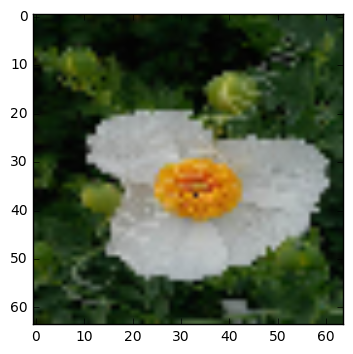

In [11]:

dir_img = join('Data/flowers/jpg', 'image_05306.jpg')
im = load_image_array(dir_img, 64)
plt.imshow(im)


In [12]:
#Compile training dataset: ID, Image (X), Embedding (Y)
img_id = flower_cap['image_list']
Y = np.zeros((flower_cap['data_length']*5,2400))
X= np.zeros((flower_cap['data_length'],64,64,3))
n=0

for i in img_id:
    for c in range(0,5):
        Y[(n*5+c),:] = flower_cap['captions'][i][c][0:2400] # take the first 2400 uni-gram
    X[n,:,:,:] = load_image_array(join('Data/flowers/jpg', i), 64)
    n += 1

In [13]:
print (X.shape)
print (Y.shape)

(8189, 64, 64, 3)
(40945, 2400)


## Conditional GAN

In [42]:
# Hyperparameters
mb_size = 128
num_epochs = 600
Z_dim = 100
image_size = 64
image_channel = 3
label_size = Y.shape[1]  #2400 for skip-thought
D_learning_rate = 0.0001
G_learning_rate = 0.0002

# Helper Functions
def plot(samples):
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(6, 6)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64))

    return fig


def generate_a_graph(i,label_test): # generate image by label
    label_y = label_test[i][0:label_size].reshape(1, label_size)
    z = np.random.uniform(-1., 1., size=[1, Z_dim])
    g = sess.run(G_sample, feed_dict={Z_ph: z, Y_real:label_y})
    return (g.reshape(image_size, image_size,image_channel))

In [43]:
def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

def batch_iter(data, label, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_true_indices = np.random.permutation(np.arange(data_size))
            shuffle_false_indices = np.random.permutation(np.arange(data_size)) # need to check this
        for batch_num in range(num_batches_per_epoch):
            random_caption_index = random.randint(0,4) # random selection of one of the 5 caption each batch
            shuffle_true_label_index = [(x*5+random_caption_index) for x in shuffle_true_indices]
            shuffle_false_label_index = [(x*5+random_caption_index) for x in shuffle_false_indices]
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            image_true =  data[shuffle_true_indices[start_index:end_index]]
            #image_false = data[shuffle_false_indices[start_index:end_index]]
            label_true = label[shuffle_true_label_index[start_index:end_index]]
            label_false = label[shuffle_false_label_index[start_index:end_index]]
            yield (image_true, label_true, label_false)

In [44]:
# Construct the conditional GAN

tf.reset_default_graph()

def xavier_init(size):
    return tf.random_normal(shape=size, stddev=(1. / tf.sqrt(size[0] / 2.)))

def generator(z, y):
    z_y = tf.concat([z, y], 1) # z_dim+2400
    # G_h1 = tf.nn.relu(tf.matmul(z_y, G_W1) + G_b1)
    #G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    #G_prob = tf.nn.sigmoid(G_log_prob)
    G_h1 = tf.layers.dense(inputs=z_y, 
                           units=8*8*3, 
                           kernel_initializer = tf.contrib.layers.xavier_initializer(),
                           bias_initializer = tf.contrib.layers.xavier_initializer(),
                           #activation=tf.nn.relu, 
                           name='G_dense')
    G_h1_norm = tf.layers.batch_normalization(inputs=G_h1, name='G_norm1')
    G_h1_relu = tf.nn.relu(G_h1_norm)
    
    G_h2 = tf.reshape(G_h1_relu, [-1, 8, 8, 3])
    G_deconv_1 = tf.layers.conv2d_transpose(G_h2, 64, 3, 
                                            strides=2, 
                                            padding="same", 
                                            kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                            bias_initializer = tf.contrib.layers.xavier_initializer(),
                                            #activation=tf.nn.relu, 
                                            name='G_deconv_1')
    G_deconv_1_norm = tf.layers.batch_normalization(inputs=G_deconv_1, name='G_norm2')
    G_deconv_1_relu = tf.nn.relu(G_deconv_1_norm)
    
    G_deconv_2 = tf.layers.conv2d_transpose(G_deconv_1_relu, 128, 3, 
                                            strides=2, 
                                            padding="same", 
                                            kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                            bias_initializer = tf.contrib.layers.xavier_initializer(),
                                            #activation=tf.nn.relu, 
                                            name='G_deconv_2')
    G_deconv_2_norm = tf.layers.batch_normalization(inputs=G_deconv_2, name='G_norm3')
    G_deconv_2_relu = tf.nn.relu(G_deconv_2_norm)
    
    G_deconv_3 = tf.layers.conv2d_transpose(G_deconv_2_relu, 3, 3, 
                                            strides=2, 
                                            padding="same", 
                                            kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                            bias_initializer = tf.contrib.layers.xavier_initializer(),
                                            #activation=tf.nn.relu, 
                                            name='G_deconv_3')
    G_deconv_3_norm = tf.layers.batch_normalization(inputs=G_deconv_3, name='G_norm4')
    print(G_deconv_3_norm.get_shape())
    return tf.tanh(G_deconv_3_norm)

def discriminator(x, y, reuse=False):
    #x_y = tf.concat([x, y], 1) #32*32*3+4800<-40*40*3
    #D_h1 = tf.nn.relu(tf.matmul(tf.contrib.layers.flatten(x_y), D_W1) + D_b1)
    #D_logit = tf.matmul(D_h1, D_W2) + D_b2
    #D_prob = tf.nn.sigmoid(D_logit)
    
    with tf.variable_scope("discriminator", reuse=reuse):

        image_input = tf.reshape(x, [-1, image_size, image_size, image_channel])

        D_conv_1 = tf.layers.conv2d(
            inputs=image_input,
            filters=32,
            kernel_size=[3, 3],
            kernel_initializer = tf.contrib.layers.xavier_initializer(),
            bias_initializer = tf.contrib.layers.xavier_initializer(),
            padding="same",
            name='D_conv_1')
        D_pool_1 = tf.layers.max_pooling2d(inputs=D_conv_1, pool_size=[2, 2], strides=2)
        D_norm_1 = tf.layers.batch_normalization(inputs=D_pool_1, name='D_norm1')
        D_relu_1 = tf.nn.leaky_relu(D_norm_1, alpha=0.05, name='D_relu_1')

        D_conv_2 = tf.layers.conv2d(
            inputs=D_relu_1,
            filters=64,
            kernel_size=[3, 3],
            kernel_initializer = tf.contrib.layers.xavier_initializer(),
            bias_initializer = tf.contrib.layers.xavier_initializer(),
            padding="same",
            name='D_conv_2')
        D_pool_2 = tf.layers.max_pooling2d(inputs=D_conv_2, pool_size=[2, 2], strides=2)
        D_norm_2 = tf.layers.batch_normalization(inputs=D_pool_2, name='D_norm2')
        D_relu_2 = tf.nn.leaky_relu(D_norm_2, alpha=0.05, name='D_relu_2')
        
        D_conv_3 = tf.layers.conv2d(
            inputs=D_relu_2,
            filters=128,
            kernel_size=[3, 3],
            kernel_initializer = tf.contrib.layers.xavier_initializer(),
            bias_initializer = tf.contrib.layers.xavier_initializer(),
            padding="same",
            name='D_conv_3')
        D_pool_3 = tf.layers.max_pooling2d(inputs=D_conv_3, pool_size=[2, 2], strides=2)
        D_norm_3 = tf.layers.batch_normalization(inputs=D_pool_3, name='D_norm3')
        D_relu_3 = tf.nn.leaky_relu(D_norm_3, alpha=0.05, name='D_relu_3')

        pool2_flat = tf.reshape(D_relu_3, [-1, int(image_size/8) * int(image_size/8) * 128])
        
        dense_input = tf.concat([pool2_flat,y], 1)

        D_h1 = tf.layers.dense(inputs=dense_input, 
                                units=128, 
                                kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                bias_initializer = tf.contrib.layers.xavier_initializer(),
                                activation=tf.nn.leaky_relu, 
                                name='D_dense_1')
        D_logit = tf.layers.dense(inputs=D_h1, 
                                    units=1, 
                                    kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                    bias_initializer = tf.contrib.layers.xavier_initializer(),
                                    activation=tf.nn.leaky_relu, 
                                    name='D_dense_2')
        D_prob = tf.nn.sigmoid(D_logit)

        return D_prob, D_logit


# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, (image_size*image_size*3)], name='X')
Y_real = tf.placeholder(tf.float32, shape=[None, label_size], name='Y_real')
Y_fake = tf.placeholder(tf.float32, shape=[None, label_size], name='Y_fake')


# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')


# losses and MaxMin
G_sample = generator(Z_ph, Y_real)

D_real, D_logit_real = discriminator(X_ph, Y_real)
#tf.get_variable_scope().reuse_variables()
D_fake, D_logit_fake = discriminator(G_sample,Y_real, reuse=True)
D_real_fake, D_logit_real_fake = discriminator(X_ph, Y_fake, reuse=True)

D_loss = -tf.reduce_mean(tf.log(D_real) + (tf.log(1. - D_fake) + tf.log(1. - D_real_fake))/2)
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Trainable W and b as variable list
t_vars = tf.trainable_variables()
    
theta_D = [var for var in t_vars if 'D_' in var.name]
theta_G = [var for var in t_vars if 'G_' in var.name]

#for var in theta_G:
#    print(var.name)


# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer(D_learning_rate,beta1=0.5).minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer(G_learning_rate,beta1=0.5).minimize(G_loss, var_list=theta_G)



(?, 64, 64, 3)


Iter: 1
D loss: 1.76
G_loss: 0.2423



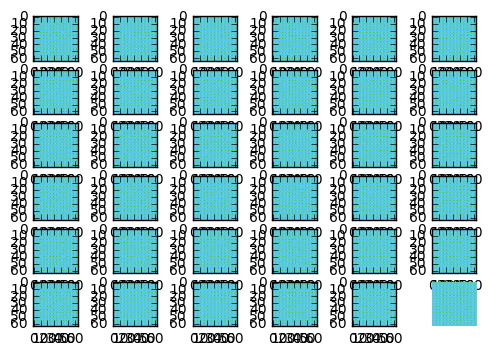

Iter: 1000
D loss: 1.284
G_loss: 1.061



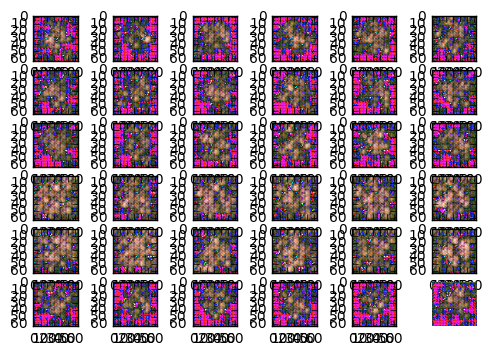

Iter: 2000
D loss: 1.195
G_loss: 1.39



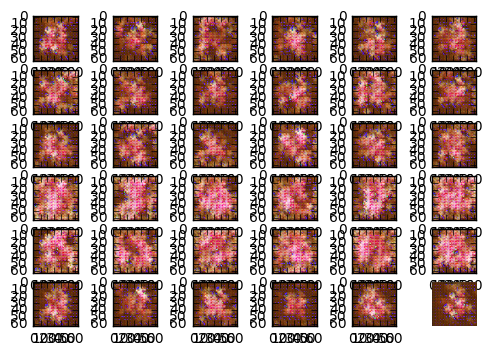

Iter: 3000
D loss: 1.234
G_loss: 1.104



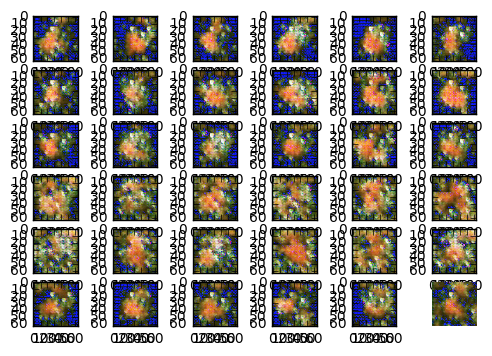

Iter: 4000
D loss: 1.287
G_loss: 0.9172



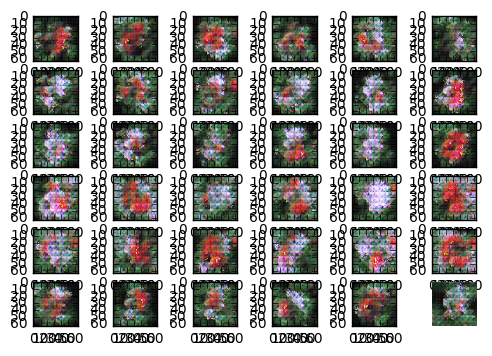

Iter: 5000
D loss: 1.188
G_loss: 1.495



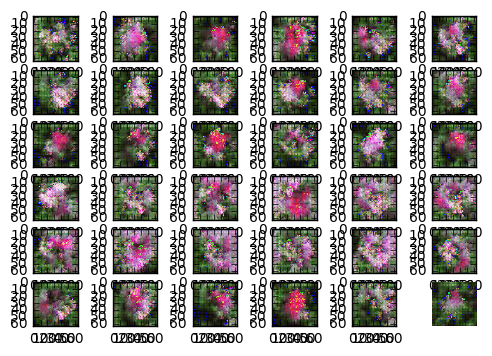

Iter: 6000
D loss: 1.184
G_loss: 1.894



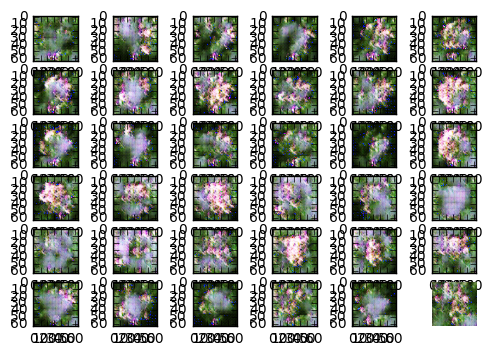

Iter: 7000
D loss: 1.133
G_loss: 1.829



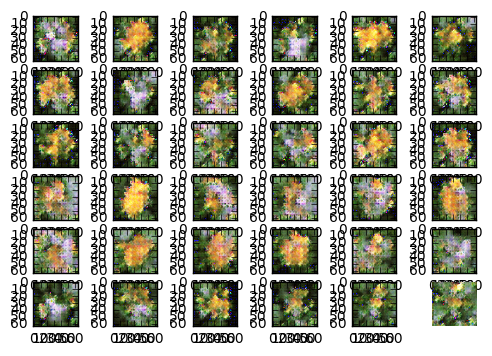

Iter: 8000
D loss: 1.138
G_loss: 1.752



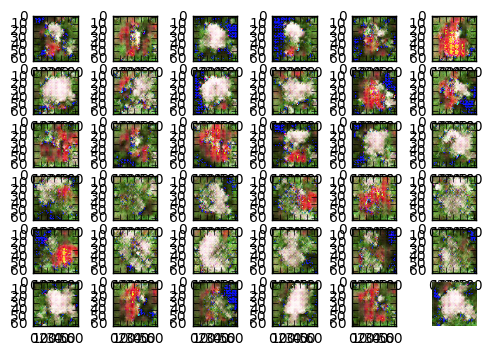

Iter: 9000
D loss: 1.075
G_loss: 2.014



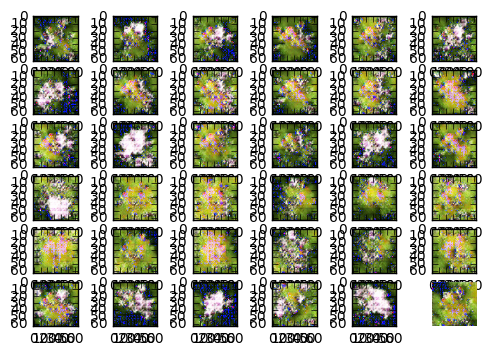

KeyboardInterrupt: 

In [45]:
## Run the conditional GAN model

# define global steps 
global_step = tf.Variable(0, name="global_step", trainable=False)
incr_global_step_op = tf.assign(global_step, global_step+1)

# define test label 
caption = [
    'the flower shown has yellow anther red pistil and bright red petals',
    'this flower has petals that are yellow, white and purple and has dark lines',
    'the petals on this flower are white with a yellow center',
    'this flower has a lot of small round pink petals.',
    'this flower is orange in color, and has petals that are ruffled and rounded.',
    'the flower has yellow petals and the center of it is brown']
label_test = encoder.encode(caption,verbose=False)


# start tf session
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0}))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

# initialize loss
D_loss_c = []
G_loss_c = []

# Run in mini batch
batches = batch_iter(X, Y, mb_size, num_epochs)
for image_true, label_true, label_false in batches:

    _, D_loss_curr, _, G_loss_curr, i = sess.run([D_solver, D_loss, G_solver, G_loss, incr_global_step_op]
                                                 ,feed_dict={X_ph: image_true.reshape([-1,(image_size*image_size*3)])
                                                             , Y_real: label_true
                                                             , Y_fake: label_false
                                                             , Z_ph:sample_Z(image_true.shape[0], Z_dim)
                                                             })
    # print some loss during the training
    if i % 100 == 0 or i==1:
        D_loss_c.append(D_loss_curr)
        G_loss_c.append(G_loss_curr)

    if i % 1000 == 0 or i==1:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        f, axarr = plt.subplots(6,6)
        for n in range(6):
            for m in range(6):
                im = generate_a_graph(n,label_test)
                plt.axis('off')
                axarr[n,m].imshow(im)
        plt.show()


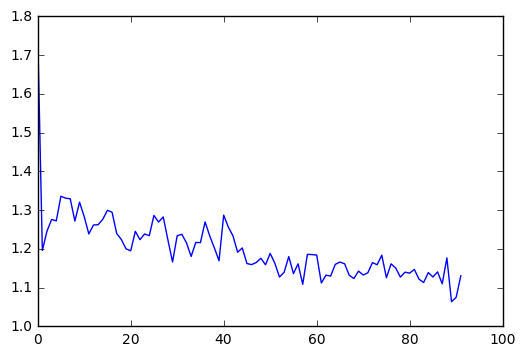

In [46]:
plt.plot(D_loss_c)
plt.show()

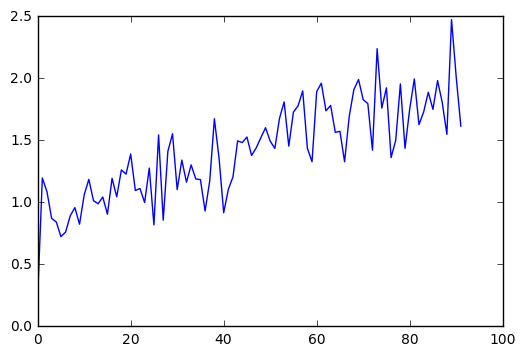

In [47]:
plt.plot(G_loss_c)
plt.show()

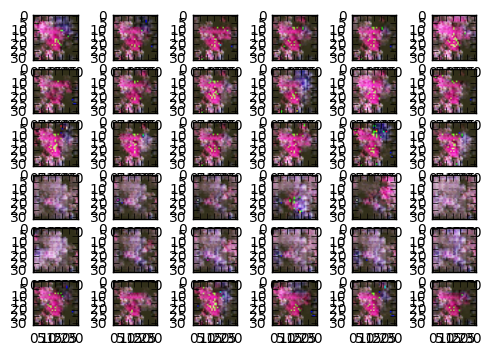

In [34]:

f, axarr = plt.subplots(6,6)
for n in range(6):
    for m in range(6):
        im = generate_a_graph(n,label_test)
        axarr[n,m].imshow(im)
plt.show()